In [37]:
import sys
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [38]:
data_path = '/content/gdrive/MyDrive/BUDA_RECON/RUN_UP_BUDA_09_07_2022/'
sys.path.insert(0,data_path)

In [46]:
import tensorflow as tf
import numpy as np
import scipy.signal
import scipy.io as sio
import time, pdb, os
import glob
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda

# Deep learning packages
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

class BUDA_DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, filename_list,num_rows, num_cols, num_coils, num_polarities, num_time_segs,batch_size,
                 shuffle=True):

        self.filename_list = filename_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = len(self.filename_list)
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.num_coils = num_coils
        self.num_polarities = num_polarities
        self.num_time_segs = num_time_segs
        self.on_epoch_end()


    def on_epoch_end(self):
        if self.shuffle:
            #Shuffle the filename list in-place
            np.random.shuffle(self.filename_list)


    def __get_data(self, filenames):

        #Ahb = np.empty((self.batch_size,self.num_rows-8,self.num_cols-8,self.num_polarities))
        csm_buda = np.empty((self.batch_size,self.num_rows,self.num_cols,self.num_coils)).astype(np.csingle)
        mask_buda = np.empty((self.batch_size,self.num_rows,self.num_cols,self.num_polarities,self.num_time_segs)).astype(np.csingle)
        wmap_buda = np.empty((self.batch_size,self.num_rows,self.num_cols,self.num_polarities,self.num_time_segs)).astype(np.csingle)
        kdata_buda = np.empty((self.batch_size,self.num_rows,self.num_cols,self.num_coils,self.num_polarities)).astype(np.csingle)
        label_img = np.empty((self.batch_size,self.num_rows+20,self.num_cols+20,1))
        b0_img = np.empty((self.batch_size,self.num_rows+20,self.num_cols+20,self.num_polarities)).astype(np.csingle)

        for idx, curr_filename in enumerate(filenames):
            kdata_buda[idx,], csm_buda[idx,], mask_buda[idx,], wmap_buda[idx,], b0_img[idx,], label_img[idx,] = self.prepare_single_input_output_pair(curr_filename)
        return tuple([kdata_buda,csm_buda,mask_buda,wmap_buda,b0_img]), label_img

    # Return the index'th batch
    def __getitem__(self, index):
        curr_filenames = self.filename_list[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(curr_filenames)

        return X, y

    def __len__(self):
        return self.num_samples // self.batch_size

    def prepare_single_input_output_pair(self,filename_one_sample):
        temp = sio.loadmat(filename_one_sample)
        # Put whatever it needs to generate Ahb, csm, mask, kdata, fully_sampled_ispace
        # for the current sample. For example,
        b0_img = temp['b0'].astype(np.csingle)
        label_img = temp['label_img'].astype(np.csingle)
        kdata_buda = 3*temp['kdata_buda'].astype(np.csingle)
        mask_buda = temp['mask_buda'].astype(np.csingle)
        csm_buda = temp['csm_buda'].astype(np.csingle)
        wmap_buda = temp['wmap_buda'].astype(np.csingle)        

        return kdata_buda, csm_buda, mask_buda, wmap_buda, b0_img, tf.reduce_mean(tf.math.abs(label_img),axis=2,keepdims=True)

In [63]:
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Add, \
    LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D, \
    Conv2DTranspose, Dropout, concatenate, SeparableConv2D, PReLU
from tensorflow.keras.models import Model

def unet(Nx,Ny,Nin,Nout):
    input = Input(shape=(Nx,Ny,Nin))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.05)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.05)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(Nout, 1)(conv9)

    model = Model(inputs = input, outputs = conv10)

    return model

In [47]:
num_rows = 300
num_cols = 300
num_coils = 12
num_time_segs = 50
num_polarities = 2
num_batchs = 2  

########################################################################################################################    
input_paths = glob.glob(os.path.join('/content/gdrive/MyDrive/BUDA_RECON/RUN_UP_BUDA_09_07_2022/TrainS/*.mat'))
decode = tf.image.decode_png

if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

def get_name(path):
    name, _ = os.path.splitext(os.path.basename(path))
    return name

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
if all(get_name(path).isdigit() for path in input_paths):
        input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
else:
        input_paths = sorted(input_paths)
               
training_gen = BUDA_DataGenerator(input_paths,num_rows, num_cols, num_coils, num_polarities, num_time_segs,num_batchs,shuffle=True)

####################################################################################
input_paths = glob.glob(os.path.join('/content/gdrive/MyDrive/BUDA_RECON/RUN_UP_BUDA_09_07_2022/ValidateS/*.mat'))
decode = tf.image.decode_png

if len(input_paths) == 0:
        raise Exception("input_dir contains no image files")

def get_name(path):
    name, _ = os.path.splitext(os.path.basename(path))
    return name

    # if the image names are numbers, sort by the value rather than asciibetically
    # having sorted inputs means that the outputs are sorted in test mode
if all(get_name(path).isdigit() for path in input_paths):
        input_paths = sorted(input_paths, key=lambda path: int(get_name(path)))
else:
        input_paths = sorted(input_paths)
        
val_gen = BUDA_DataGenerator(input_paths,num_rows, num_cols, num_coils, num_polarities, num_time_segs,num_batchs,shuffle=True)

In [64]:
######## ##################################################################################
fft2c = Lambda(lambda x: fft2c_tf(x))
ifft2c = Lambda(lambda x: ifft2c_tf(x))
fft2c_coil = Lambda(lambda x: fft2c_coil_tf(x))
ifft2c_coil = Lambda(lambda x: ifft2c_coil_tf(x))
fft2c_coil_buda = Lambda(lambda x: fft2c_coil_tf_buda(x))
ifft2c_coil_buda = Lambda(lambda x: ifft2c_coil_tf_buda(x))   


complex_to_real = Lambda(lambda x: complex_to_real_tf(x))
real_to_complex = Lambda(lambda x: real_to_complex_tf(x))

virtual_coil = Lambda(lambda x: virtual_coil_tf(x))
actual_coil = Lambda(lambda x: actual_coil_tf(x))

#######################################################################################
def data_normalize(data,batch):
    max_val= tf.math.reduce_max(data,axis=(1, 2))
    norm_data = []
    for it in range(batch):
        tmp = data[it,:,:,:]/max_val[it]
        norm_data.append(tmp)
        
    return tf.stack(norm_data,axis=0)

def virtual_coil_tf(image):
    vc_image = tf.transpose(image,(0,2,1,3),conjugate=True)
    image_out = tf.concat((image,vc_image),axis=3) 
    return image_out

def actual_coil_tf(image):
    tmp1 = 0.5*(image[...,0]+tf.transpose(image[...,2],(0,2,1),conjugate=True))
    tmp2 = 0.5*(image[...,1]+tf.transpose(image[...,3],(0,2,1),conjugate=True))
    image_out = tf.stack([tmp1,tmp2],axis = -1) 
    return image_out

def complex_to_real_tf(image):
    image_out = tf.stack([tf.math.real(image), tf.math.imag(image)], axis=-1)
    shape_out = tf.concat([tf.shape(image)[:-1], [image.shape[-1]*2]],axis=0)
    image_out = tf.reshape(image_out, shape_out)
    return image_out

def real_to_complex_tf(image):
    image_out = tf.reshape(image, [-1, 2])
    image_out = tf.complex(image_out[:, 0], image_out[:, 1])
    shape_out = tf.concat([tf.shape(image)[:-1], [image.shape[-1] // 2]],axis=0)
    image_out = tf.reshape(image_out, shape_out)
    return image_out


def fft2c_tf(x):
    # x: [batch, row, col] ... x in this case
    # tf.signal.fft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    # Inner-most dimension = right-most dimension

    Fx = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(x, axes=(-2, -1))), axes=(-2, -1))/tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return Fx

def ifft2c_tf(x):
    # x: [batch, row, col] ...k in this case
    # tf.signal.ifft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    Ft_x = tf.signal.ifftshift(tf.signal.ifft2d(tf.signal.ifftshift(x, axes=(-2, -1))), axes=(-2, -1))*tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return Ft_x

# fft2c with coil dimension
def fft2c_coil_tf(x):
    # x: [batch, row, col, coil] ... Cx in this case
    # tf.signal.fft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    # Inner-most dimension = right-most dimension
    # So, we need to swap things around
    x = tf.transpose(x, perm=(0, 3, 1, 2))  # -> [batch, coil, row, col]

    Fx = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(x, axes=(-2, -1))), axes=(-2, -1))/tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return tf.transpose(Fx, perm=(0, 2, 3, 1))  # -> Back to [batch, row, col, coil]

# ifft2c with coil dimension
def ifft2c_coil_tf(x):
    # x: [batch, row, col, coil] ...Mt_k in this case
    # tf.signal.ifft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    x = tf.transpose(x, perm=(0, 3, 1, 2))  # -> [row,col,coil, batch]
    Ft_x = tf.signal.ifftshift(tf.signal.ifft2d(tf.signal.ifftshift(x, axes=(-2, -1))), axes=(-2, -1))*tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return tf.transpose(Ft_x, perm=(0, 2, 3, 1))  # -> Back to [batch, row, col, coil]

# fft2c with time segmentation & polarities dimension
def fft2c_coil_tf_buda(x):
    # x: [batch, row, col, coil, polar] ... Cx in this case
    # tf.signal.fft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    # Inner-most dimension = right-most dimension
    # So, we need to swap things around
    x = tf.transpose(x, perm=(0, 4, 3, 1, 2))  # -> [batch, polar, coil, row, col]

    Fx = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(x, axes=(-2, -1))), axes=(-2, -1))/tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return tf.transpose(Fx, perm=(0, 3, 4, 2, 1))  # -> Back to [batch, row, col, coil, polar]

# ifft2c with coil dimension
def ifft2c_coil_tf_buda(x):
    # x: [batch, row, col, coil, polar, tseg] ...Mt_k in this case
    # tf.signal.ifft2d computes the 2-dimensional discrete Fourier transform over the inner-most 2 dimensions of input.
    x = tf.transpose(x, perm=(0, 4, 3, 1, 2))  # -> [row,col,coil, batch]
    Ft_x = tf.signal.ifftshift(tf.signal.ifft2d(tf.signal.ifftshift(x, axes=(-2, -1))), axes=(-2, -1))*tf.cast(tf.math.sqrt(float(x.shape[-2]*x.shape[-1])),dtype=tf.complex64)
    return tf.transpose(Ft_x, perm=(0, 3, 4, 2, 1))  # -> Back to [batch, row, col, coil]

def mbir_buda_transpose(kspace, csm, mask, wmap, num_rows, num_cols, num_coils, num_segs, num_polarities):
    """Apply transpose model.
    k-Space domain to image domain
    """
##
    #num_batchs = kspace.shape[0]
    csm = tf.tile(tf.expand_dims(csm,axis=-1), [1, 1, 1, 1, num_polarities])
    #csm = tf.tile(tf.expand_dims(csm,axis=-1), [1, 1, 1, 1, 1, num_segs])    
    wmap = tf.tile(tf.expand_dims(wmap,axis=3), [1, 1, 1, num_coils, 1, 1])
    mask = tf.tile(tf.expand_dims(mask,axis=3), [1, 1, 1, num_coils, 1, 1])
    #kspace = tf.tile(tf.expand_dims(kspace,axis=-1), [1, 1, 1, 1, 1, num_segs])
##                                        ##############################################################################################
    out = csm[:,:,:,1,:]*0
    for it in range(num_segs):
      tmp_k = kspace*mask[:,:,:,:,:,it]
    #kspace = tf.reshape(kspace,[num_batchs,num_rows,num_cols,num_coils*num_polarities*num_segs])
      tmp_i = ifft2c_coil_buda(tmp_k)
    #tmp_i = tf.reshape(tmp_i,[num_batchs,num_rows,num_cols,num_coils, num_polarities, num_segs])
   
      #out = tf.reduce_sum(tmp_i*tf.math.conj(wmap)*tf.math.conj(csm),axis=5)
      tmp_i = tmp_i*tf.math.conj(wmap[:,:,:,:,:,it])*tf.math.conj(csm)
      out = tf.add(tf.reduce_sum(tmp_i,axis=3),out)

    out = tf.image.resize_with_crop_or_pad(out,num_rows+20,num_rows+20) ###########################################################

    return out

def mbir_buda_forward(img, csm, mask, wmap, num_rows, num_cols, num_coils, num_segs, num_polarities):
    """Apply forward model.
    k-Space domain to image domain
    """
    img = tf.image.resize_with_crop_or_pad(img,num_rows,num_cols)
##
    csm = tf.tile(tf.expand_dims(csm,axis=-1), [1, 1, 1, 1, num_polarities])
    #csm = tf.tile(tf.expand_dims(csm,axis=-1), [1, 1, 1, 1, 1, num_segs])    
    wmap = tf.tile(tf.expand_dims(wmap,axis=3), [1, 1, 1, num_coils, 1, 1])
    mask = tf.tile(tf.expand_dims(mask,axis=3), [1, 1, 1, num_coils, 1, 1])
    img = tf.tile(tf.expand_dims(img,axis=3), [1, 1, 1, num_coils, 1])
    #img = tf.tile(tf.expand_dims(img,axis=-1), [1, 1, 1, 1, 1, num_segs])
##
    out = csm*0
    for it in range(num_segs):
      tmp_i = img*wmap[:,:,:,:,:,it]*csm
    #img = tf.reshape(img,[num_batchs, num_rows, num_cols, num_coils*num_polarities*num_segs])
      tmp_k = fft2c_coil_buda(tmp_i)
    #tmp_k = tf.reshape(tmp_k,[num_batchs, num_rows, num_cols, num_coils, num_polarities, num_segs])
      tmp_k = tmp_k*mask[:,:,:,:,:,it]
      out = tf.add(out,tmp_k)#tf.reduce_sum(tmp_k,axis=5)

    return out

class compute_Ah(tf.keras.layers.Layer):

    # __init__ , where you can do all input-independent initialization
    def __init__(self):
        super(compute_Ah, self).__init__()
        self.mbir_buda_transpose = mbir_buda_transpose

    # # build, where you know the shapes of the input tensors and can do the rest of the initialization
    def build(self, input_shape):
        super(compute_Ah, self).build(input_shape)

    # call, where you do the forward computation
    def call(self, x, csm, mask, wmap, num_rows, num_cols, num_coils, num_segs, num_polarities):
        # inputs: x, C, M, W

        # Compute Ah(A(x))
        return self.mbir_buda_transpose(x, csm, mask, wmap, num_rows, num_cols, num_coils, num_segs, num_polarities)


class getDataTerm_AhAx(tf.keras.layers.Layer):

    # __init__ , where you can do all input-independent initialization
    def __init__(self):
        super(getDataTerm_AhAx, self).__init__()

    # # build, where you know the shapes of the input tensors and can do the rest of the initialization
    def build(self, input_shape):
        super(getDataTerm_AhAx, self).build(input_shape)

    # call, where you do the forward computation
    def call(self, x, csm, mask, wmap, num_rows, num_cols, num_coils, num_segs, num_polarities):
        # inputs: x, C, M, W

        # Compute Ah(A(x))
        return mbir_buda_transpose(mbir_buda_forward(x, csm, mask, wmap, num_rows, num_cols, num_coils, num_segs, num_polarities), csm, mask, wmap, num_rows, num_cols, num_coils, num_segs, num_polarities)


In [65]:
###################################
import sys
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Subtract, Lambda, LayerNormalization
from tensorflow.keras.models import Model
from utils.compute_nrmse import compute_nrmse
# from models.tensorflow_utils import fft2c, ifft2c
# from models.tensorflow_utils import complex2real, real2complex
# from models.buda_utils import ifft2c, fft2c

def KINet_large(data_consistency_type,
         num_rows,
         num_cols,
         num_coils,
         num_segs,
         num_polarities,
         batch_size,
         num_GD_blocks=6,
         num_inner_GD_iters=1,
         GD_step_size=0.9,
         activation_type='prelu',
         use_DL_regularizer=True,
         pretrained_reg_net_path=None,
         pretrained_inet_path=None,
         data_consistency_before_reg=True,
         use_layer_norm=False):

    if pretrained_inet_path is not None:
        pretrained_weights_reg_path = None

    # undersampled_ispace_buda = Input(shape=(num_rows-8, num_cols-8), dtype=tf.complex64)  # undersampled (image space)
    csm_buda = Input(shape=(num_rows, num_cols, num_coils), dtype=tf.complex64)
    mask_buda = Input(shape=(num_rows, num_cols, num_polarities, num_segs), dtype=tf.complex64)
    kdata_buda = Input(shape=(num_rows, num_cols,num_coils, num_polarities), dtype=tf.complex64)
    wmap_buda = Input(shape=(num_rows, num_cols,num_polarities, num_segs), dtype=tf.complex64)
    b0_img = Input(shape=(num_rows+20, num_cols+20,num_polarities), dtype=tf.complex64)

    if use_DL_regularizer:

        # from models.UNet2D_ import UNet2D_
        reg_last = unet(num_rows+20, num_cols+20, 1,1)
        regI_models = {}
        regK_models = {}
        for idx_block in range(round(num_GD_blocks/2)):
            # regI_models[str(idx_block)] = UNet2D_(im_size=num_rows+20, kernel_size=3, num_out_chan_highest_level=64,
            #                depth=3, num_chan_increase_rate=2, activation_type=activation_type,
            #                dropout_rate=0.2, SEPARABLE_CONV=False, SKIP_CONNECTION_AT_THE_END=True,
            #                num_input_chans=16, num_output_chans=8)           
            # regK_models[str(idx_block)] = UNet2D_(im_size=num_rows+20, kernel_size=3, num_out_chan_highest_level=64,
            #                depth=3, num_chan_increase_rate=2, activation_type=activation_type,
            #                dropout_rate=0.2, SEPARABLE_CONV=False, SKIP_CONNECTION_AT_THE_END=True,
            #                num_input_chans=16, num_output_chans=8)
            regI_models[str(idx_block)] = unet(num_rows+20, num_cols+20, 16, 8)
            regK_models[str(idx_block)] = unet(num_rows+20, num_cols+20, 16, 8)

            if pretrained_reg_net_path is not None:
                regI_models[str(idx_block)].load_weights(pretrained_reg_net_path)
                regK_models[str(idx_block)].load_weights(pretrained_reg_net_path)
    
########################################################################################################################
    b0_i = virtual_coil(b0_img)
    b0_k = fft2c_coil(b0_i)
    b0_i = complex_to_real(b0_i)
    b0_k = complex_to_real(b0_k)
########################################################################################################################
    sc_factor = 1
    x = compute_Ah()(kdata_buda, csm_buda, mask_buda, wmap_buda, num_rows, num_cols, num_coils, num_segs, num_polarities)
    Ahb = x
    compute_AhAx_model = getDataTerm_AhAx()

    for idx_block in range(round(num_GD_blocks/2)):

        if data_consistency_before_reg:

            for idx_inner_iter in range(num_inner_GD_iters):
                AhAx = compute_AhAx_model(x, csm_buda, mask_buda, wmap_buda, num_rows, num_cols, num_coils, num_segs, num_polarities)

                # Compute the gradient of the data consistency term: Ah(A(x)) - Ah(b)
                # GD_grad = AhAx - Ahb  # grad_x 1/2||Ax-b||^2 = Ah(A(x)) - Ah(b)
                GD_grad = Subtract()([AhAx, Ahb])

                # Update the solution: shape = batch x 200 x 200
                # x = x - GD_step_size * GD_grad  # [None, row,col,coil] complex64

                temp = Lambda(lambda x: x * GD_step_size)(GD_grad)
                x = Subtract()([x, temp])

            # Include UNet as a regularizer in k-space
            if use_DL_regularizer:

                x = virtual_coil(x) ## complex conjugate channel ... actual & virtual up & down ... 4 channels
                # image- to k-space
                x = fft2c_coil(x)*sc_factor

                # complex to real: output shape = batch x row x col x 2 (real/imag)
                x = complex_to_real(x) ## complex conjugate channel ... actual & virtual up & down .. real & imaginary ... 8 channels

                # Pass the images to the regularization network
                if use_layer_norm:
                    x = LayerNormalization(axis=[1,2,3])(x)
                x = regK_models[str(idx_block)](tf.concat(axis=3, values=[x, b0_k]))

                # Real to complex               
                x = real_to_complex(x)

                # k- to image-space
                x = ifft2c_coil(x)/sc_factor
                x = actual_coil(x) ## back to actual up&down complex number ... 2 channels

            for idx_inner_iter in range(num_inner_GD_iters):
                AhAx = compute_AhAx_model(x, csm_buda, mask_buda, wmap_buda, num_rows, num_cols, num_coils, num_segs, num_polarities)

                # Compute the gradient of the data consistency term: Ah(A(x)) - Ah(b)
                # GD_grad = AhAx - Ahb  # grad_x 1/2||Ax-b||^2 = Ah(A(x)) - Ah(b)
                GD_grad = Subtract()([AhAx, Ahb])

                # Update the solution: shape = batch x 200 x 200
                # x = x - GD_step_size * GD_grad  # [None, row,col,coil] complex64

                temp = Lambda(lambda x: x * GD_step_size)(GD_grad)
                x = Subtract()([x, temp])

            # Include UNet as a regularizer in image-space
            if use_DL_regularizer:
                x = virtual_coil(x)
                # complex to real: output shape = batch x row x col x 2 (real/imag)
                x = complex_to_real(x)

                # Pass the images to the regularization network
                if use_layer_norm:
                    x = LayerNormalization(axis=[1,2,3])(x)
                x = regI_models[str(idx_block)](tf.concat(axis=3, values=[x, b0_i]))

                # Real to complex
                x = real_to_complex(x)
                x = actual_coil(x)
                   
        else:

            # Include UNet as a regularizer in k-space
            if use_DL_regularizer:
                x = virtual_coil_tf(x)
                # image- to k-space
                x = fft2c_coil(x)*sc_factor

                # complex to real: output shape = batch x row x col x 2 (real/imag)
                x = complex_to_real(x)

                # Pass the images to the regularization network
                if use_layer_norm:
                    x = LayerNormalization(axis=[1,2,3])(x)
                x = regK_models[str(idx_block)](tf.concat(axis=3, values=[x, b0_k]))

                # Real to complex
                x = real_to_complex(x)

                # k- to image-space
                x = ifft2c_coil(x)/sc_factor
                x = actual_coil(x)

            for idx_inner_iter in range(num_inner_GD_iters):
                AhAx = compute_AhAx_model(x, csm_buda, mask_buda, wmap_buda, num_rows, num_cols, num_coils, num_segs, num_polarities)

                # Compute the gradient of the data consistency term: Ah(A(x)) - Ah(b)
                # GD_grad = AhAx - Ahb  # grad_x 1/2||Ax-b||^2 = Ah(A(x)) - Ah(b)
                GD_grad = Subtract()([AhAx, Ahb])


                # Update the solution: shape = batch x 200 x 200
                # x = x - GD_step_size * GD_grad  # [None, row,col,coil] complex64

                temp = Lambda(lambda x: x * GD_step_size)(GD_grad)
                x = Subtract()([x, temp])

            # Include UNet as a regularizer in image-space
            if use_DL_regularizer:
                x = virtual_coil(x)
                # complex to real: output shape = batch x row x col x 2 (real/imag)
                x = complex_to_real(x)

                # Pass the images to the regularization network
                if use_layer_norm:
                    x = LayerNormalization(axis=[1,2,3])(x)
                x = regI_models[str(idx_block)](tf.concat(axis=3, values=[x, b0_i]))

                # Real to complex
                x = real_to_complex(x)
                x = actual_coil(x)

            for idx_inner_iter in range(num_inner_GD_iters):
                AhAx = compute_AhAx_model(x, csm_buda, mask_buda, wmap_buda, num_rows, num_cols, num_coils, num_segs, num_polarities)

                # Compute the gradient of the data consistency term: Ah(A(x)) - Ah(b)
                # GD_grad = AhAx - Ahb  # grad_x 1/2||Ax-b||^2 = Ah(A(x)) - Ah(b)
                GD_grad = Subtract()([AhAx, Ahb])


                # Update the solution: shape = batch x    200 x 200
                # x = x - GD_step_size * GD_grad  # [None, row,col,coil] complex64

                temp = Lambda(lambda x: x * GD_step_size)(GD_grad)
                x = Subtract()([x, temp])

    #output_data = complex_to_real(x)#tf.concat(axis=3, values=[complex_to_real(x), complex_to_real(b0_img)])
    x = tf.reduce_mean(tf.math.abs(x),axis=3,keepdims=True)
    x = data_normalize(x,batch_size)
    output_data = reg_last(x)

    

    # model = Model(inputs=[undersampled_ispace_buda, csm_buda, mask_buda, wmap_buda, kdata_buda], outputs=output_data)
    model = Model(inputs=[kdata_buda, csm_buda, mask_buda, wmap_buda, b0_img], outputs=output_data)

    if pretrained_inet_path is not None:
        model.load_weights(pretrained_inet_path)

    return model

In [66]:
# "Important" parameters
model_type = 'ki-net' # Options: 'unet', 'inet' 
num_GD_blocks = 6
num_inner_GD_iters = 1
GD_step_size = 0.9 # Step size for the data-consistency-gradient update
data_consistency_type = 'sense-buda'    
data_consistency_before_reg = True # For 'inet', 'knet', 'kikinet'
use_DL_regularize = True
# Deep learning parameters
num_epochs = 500
loss = 'nrmse'
activation_type = 'prelu'
learning_rate_base = 1e-4
batch_size = num_batchs 


tensorboard_filepath = os.path.join(data_path,'results')
model_checkpoint_filepath = os.path.join(data_path,'trained_weights', 'KI_NET.hdf5')

pre_train_path = ""
pretrained_reg_net_path = ""
pretrained_unrolled_net_path = os.path.join(data_path,'trained_weights', 'KI_NET.hdf5')

if not os.path.exists(pretrained_reg_net_path):
    pretrained_reg_net_path = None
   
if not os.path.exists(pretrained_unrolled_net_path):
    pretrained_unrolled_net_path = None

##############################################################3
if model_type == 'ki-net':
    model = KINet_large(data_consistency_type,
                 num_rows,
                 num_cols,
                 num_coils,
                 num_time_segs,
                 num_polarities,
                 batch_size,
                 num_GD_blocks,
                 num_inner_GD_iters,
                 GD_step_size,
                 activation_type,
                 use_DL_regularizer=True,
                 pretrained_reg_net_path=pretrained_reg_net_path,
                 pretrained_inet_path=pretrained_unrolled_net_path,
                 data_consistency_before_reg=data_consistency_before_reg,
                 use_layer_norm = False)
 
elif model_type == 'unet':
    model = UNet2D_(im_size=num_rows, kernel_size=3, num_out_chan_highest_level=64, 
                   depth=5, num_chan_increase_rate=2, activation_type=activation_type, 
                   dropout_rate=0.05,SEPARABLE_CONV=False, SKIP_CONNECTION_AT_THE_END=True, 
                   num_input_chans=4, num_output_chans=4)
    
    if pretrained_reg_net_path is not None:
        model.load_weights(pretrained_reg_net_path)

####################################################################
# Compile the model
adam_opt = Adam(learning_rate=learning_rate_base, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-3)
tbCallBack = TensorBoard(log_dir=tensorboard_filepath, histogram_freq=0, write_graph=False, write_images=False)
checkpointerCallBack = ModelCheckpoint(filepath=model_checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

if loss == 'nrmse':
    # Objective function
    def my_objective_function(y_true, y_pred):
        return 100 * K.sqrt(K.sum(K.square(y_pred - y_true))) / K.sqrt(K.sum(K.square(y_true)))

    model.compile(loss=my_objective_function, optimizer=adam_opt)
else:
    model.compile(loss=loss, optimizer=adam_opt)
    

In [ ]:
model.summary()

In [67]:
hist = model.fit(x=training_gen,
                     epochs=num_epochs, 
                     verbose=2, 
                     callbacks=[tbCallBack,checkpointerCallBack], 
                     validation_data=val_gen, 
                     shuffle=True, 
                     initial_epoch=0)

Epoch 1/500

Epoch 1: val_loss improved from inf to 96.30639, saving model to /content/gdrive/MyDrive/BUDA_RECON/RUN_UP_BUDA_09_07_2022/trained_weights/KI_NET.hdf5
7/7 - 203s - loss: 96.7144 - val_loss: 96.3064 - 203s/epoch - 29s/step
Epoch 2/500

Epoch 2: val_loss improved from 96.30639 to 95.62044, saving model to /content/gdrive/MyDrive/BUDA_RECON/RUN_UP_BUDA_09_07_2022/trained_weights/KI_NET.hdf5
7/7 - 38s - loss: 96.0145 - val_loss: 95.6204 - 38s/epoch - 5s/step
Epoch 3/500

Epoch 3: val_loss improved from 95.62044 to 94.94852, saving model to /content/gdrive/MyDrive/BUDA_RECON/RUN_UP_BUDA_09_07_2022/trained_weights/KI_NET.hdf5
7/7 - 38s - loss: 95.3405 - val_loss: 94.9485 - 38s/epoch - 5s/step
Epoch 4/500

Epoch 4: val_loss improved from 94.94852 to 94.29260, saving model to /content/gdrive/MyDrive/BUDA_RECON/RUN_UP_BUDA_09_07_2022/trained_weights/KI_NET.hdf5
7/7 - 37s - loss: 94.6746 - val_loss: 94.2926 - 37s/epoch - 5s/step
Epoch 5/500

Epoch 5: val_loss improved from 94.29260 

In [ ]:
t=time.time()
recon_i = model.predict(training_gen)
elapsed = time.time()-t

recon_c = real_to_complex(recon_i)

In [ ]:
recon_c = np.mean(np.abs(recon_c),axis=3)

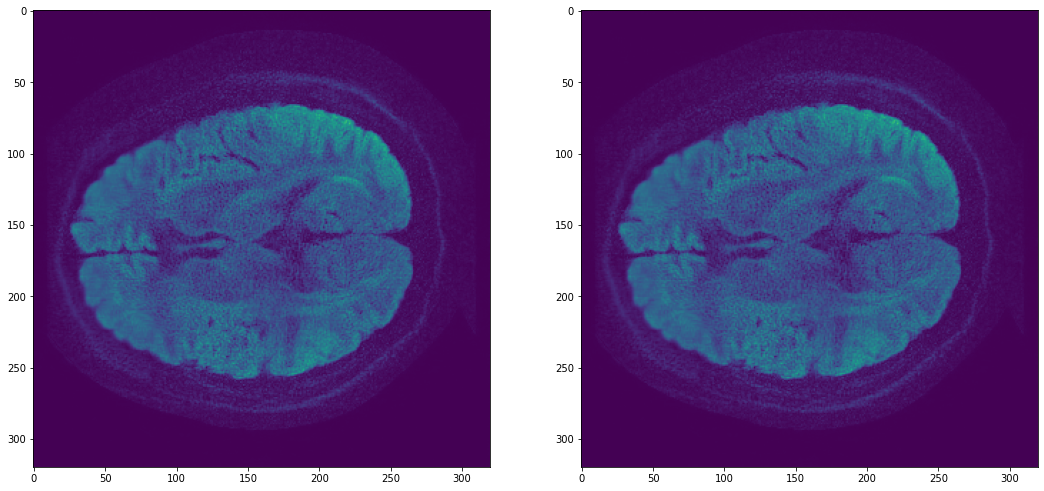

In [ ]:
sl = 25
plt.figure(figsize=(18, 18)) 
plt.subplot(1,2,1)
plt.imshow(np.abs(recon_c[sl,:,:]))
plt.clim(0,1)
plt.subplot(1,2,2)
plt.imshow(np.abs(recon_c[sl,:,:]))
plt.clim(0,1)